In [1]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def R_z(theta):
    R = np.eye(4,4)
    R[0,:2] = [np.cos(theta), -np.sin(theta)]
    R[1,:2] = [np.sin(theta), np.cos(theta)]
    return R

def T_z(theta, t):
    T = R_z(theta)
    T[:3,3] = t
    return T
    
def dist(p,q):
    return np.linalg.norm(p-q)

def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth12)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth13)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth23)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def vee(xi):
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T
    
def exp_T(xi):
    return scipy.linalg.expm(vee(xi))

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
%matplotlib notebook
ttfu = importlib.reload(ttfu)
path = "./data/raw_data/20220523_other/GP-10-20_"

trimble_1 = ttfu.read_prediction_data_resection_csv_file(path+"1.csv")
trimble_2 = ttfu.read_prediction_data_resection_csv_file(path+"2.csv")
trimble_3 = ttfu.read_prediction_data_resection_csv_file(path+"3.csv")

In [3]:
#print(np.array(trimble_1))

In [4]:
ttfu = importlib.reload(ttfu)
index1 = ttfu.find_not_moving_points_GP(np.array(trimble_1), 1, 1/5)  # 5Hz
index2 = ttfu.find_not_moving_points_GP(np.array(trimble_2), 1, 1/5)  
index3 = ttfu.find_not_moving_points_GP(np.array(trimble_3), 1, 1/5)  

In [5]:
#p1s_l = np.array(trimble_1)[:,1:5]
#p2s_l = np.array(trimble_2)[:,1:5]
#p3s_l = np.array(trimble_3)[:,1:5]
p1s_l = np.array(trimble_1)[index1,1:5]
p2s_l = np.array(trimble_2)[index1,1:5]
p3s_l = np.array(trimble_3)[index1,1:5]
print(p1s_l)

[[  0.70021028   3.89485442  -0.63900376   1.        ]
 [  0.70021082   3.89473568  -0.63906932   1.        ]
 [  0.70021534   3.89464407  -0.6390948    1.        ]
 ...
 [ 55.42325726 155.22349431   0.77890942   1.        ]
 [ 55.42326406 155.22387317   0.779013     1.        ]
 [ 55.423331   155.22390848   0.77898631   1.        ]]


<IPython.core.display.Javascript object>


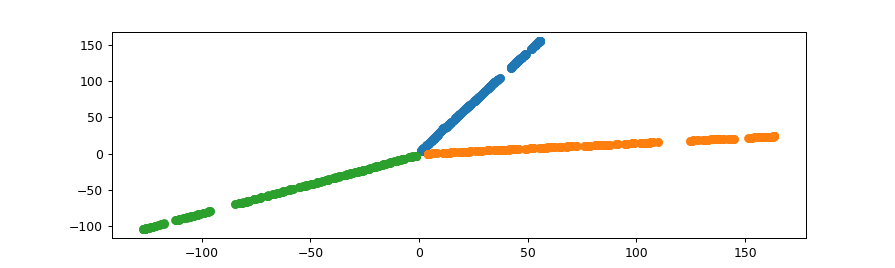

In [6]:
%matplotlib notebook

plt.figure(figsize=(10,3))
plt.scatter(p1s_l[:,0],p1s_l[:,1])
plt.scatter(p2s_l[:,0],p2s_l[:,1])
plt.scatter(p3s_l[:,0],p3s_l[:,1])

plt.show()

In [7]:
# 12 03 2022
#Dist_prism_12 = 0.8860734460339026
#Dist_prism_13 = 0.8303896290142598
#Dist_prism_23 = 1.0393117663247973

# 14 03 2022 / 16 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 05 05 2022
#Dist_prism_12 = 0.3819811991689936
#Dist_prism_13 = 0.4426382054042266
#Dist_prism_23 = 0.2564685508415531

# 31 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 27 04 2022
#Dist_prism_12 = 0.8856608085851714
#Dist_prism_13 = 0.8264452483880412
#Dist_prism_23 = 1.0384219210289538

# 23 05 2022
Dist_prism_12 = 0.3851913749758221
Dist_prism_13 = 0.4433899497583272
Dist_prism_23 = 0.25861327466684897

f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23)

res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23), 
                             x0=np.zeros((12,1)))

print(res.fun)
xi_12 = res.x[:6]
xi_13 = res.x[6:] 
T12 = exp_T(xi_12)
T13 = exp_T(xi_13)

0.6952329641497343


In [8]:
#p1s_r = p1s_l
#p2s_r = T12@p2s_l.T
#p3s_r = T13@p3s_l.T

p1s_r = np.array(trimble_1)[:,1:5]
p2s_r = T12@np.array(trimble_2)[:,1:5].T
p3s_r = T13@np.array(trimble_3)[:,1:5].T

print(T12)
print(T13)

T12c = np.array([[ 9.99808290e-01, -1.95801012e-02, -5.15885290e-05, -9.48479052e-01],
 [ 1.95801026e-02,  9.99808291e-01,  2.51216034e-05, -1.40329883e+00],
 [ 5.10867555e-05, -2.61268960e-05,  9.99999998e-01,  3.48429550e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T13c = np.array([[ 3.86799805e-01,  9.22163703e-01,  1.26630201e-04,  1.55275674e+00],
 [-9.22163682e-01,  3.86799824e-01, -2.00930146e-04,  1.18520941e+00],
 [-2.34271027e-04, -3.90540306e-05,  9.99999972e-01,  1.22234265e-01],
 [ 0.00000000e+00 , 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
print(T12c)
print(T13c)

[[ 0.43486847 -0.57069183 -0.69656316 -1.58502966]
 [ 0.89359191  0.3690768   0.25549131  0.57519938]
 [ 0.1112785  -0.73354833  0.67046547 -0.19288185]
 [ 0.          0.          0.          1.        ]]
[[-0.83136736  0.48433823 -0.27247897  0.75867579]
 [-0.52493128 -0.84537206  0.09896077  1.27368718]
 [-0.18241563  0.22530548  0.95705902  0.37005858]
 [ 0.          0.          0.          1.        ]]
[[ 9.99808290e-01 -1.95801012e-02 -5.15885290e-05 -9.48479052e-01]
 [ 1.95801026e-02  9.99808291e-01  2.51216034e-05 -1.40329883e+00]
 [ 5.10867555e-05 -2.61268960e-05  9.99999998e-01  3.48429550e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 3.86799805e-01  9.22163703e-01  1.26630201e-04  1.55275674e+00]
 [-9.22163682e-01  3.86799824e-01 -2.00930146e-04  1.18520941e+00]
 [-2.34271027e-04 -3.90540306e-05  9.99999972e-01  1.22234265e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<IPython.core.display.Javascript object>


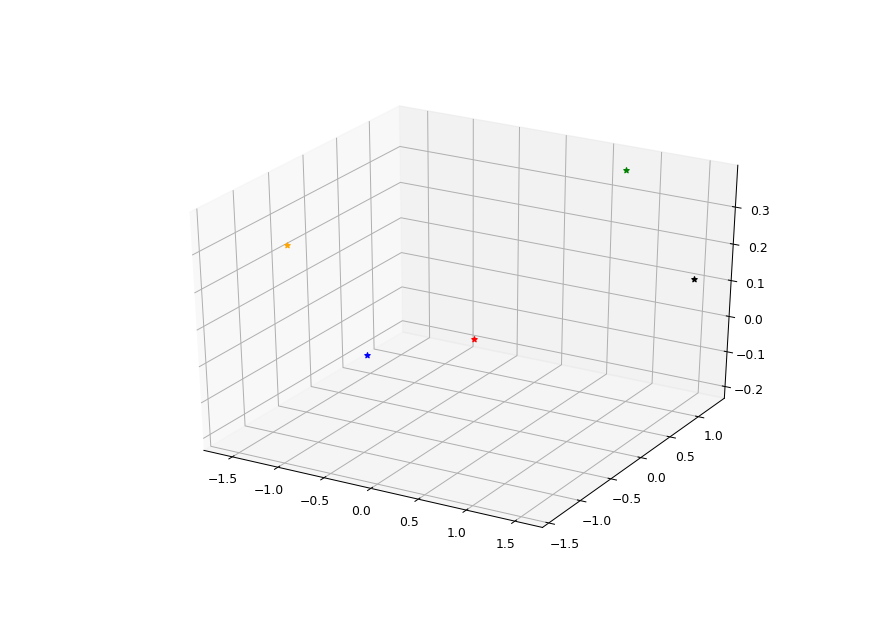

/home/norlab/python-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax = plt.axes(projection ="3d")
ax.scatter3D(0, 0, 0, c='red', marker='*', label="Theodolite 1")
ax.scatter3D(T12[0,3], T12[1,3], T12[2,3], c='blue', marker='*', label="Theodolite 2")
ax.scatter3D(T13[0,3], T13[1,3], T13[2,3], c='green', marker='*', label="Theodolite 3")
ax.scatter3D(T12c[0,3], T12c[1,3], T12c[2,3], c='orange', marker='*', label="Theodolite 2")
ax.scatter3D(T13c[0,3], T13c[1,3], T13c[2,3], c='black', marker='*', label="Theodolite 3")
plt.show()

<IPython.core.display.Javascript object>


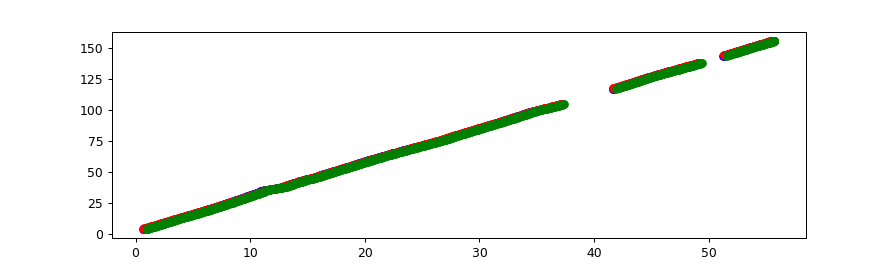

In [10]:
%matplotlib notebook

p2s_rarr = np.array(p2s_r).T
p3s_rarr = np.array(p3s_r).T

plt.figure(figsize=(10,3))
plt.scatter(p1s_r[:,0],p1s_r[:,1], color='b')
plt.scatter(p2s_rarr[:,0],p2s_rarr[:,1], color='r')
plt.scatter(p3s_rarr[:,0],p3s_rarr[:,1], color='g')
plt.show()

<IPython.core.display.Javascript object>


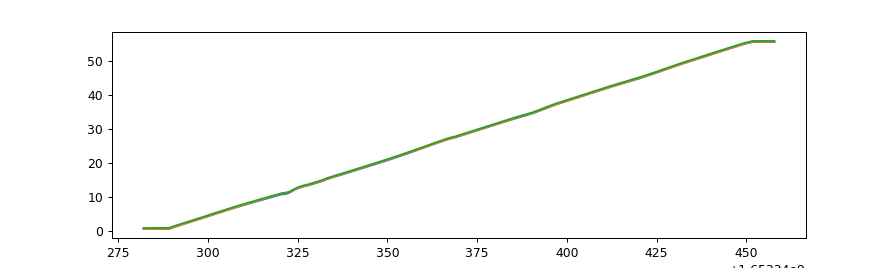

In [11]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,0])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,0])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,0])
plt.show()

<IPython.core.display.Javascript object>


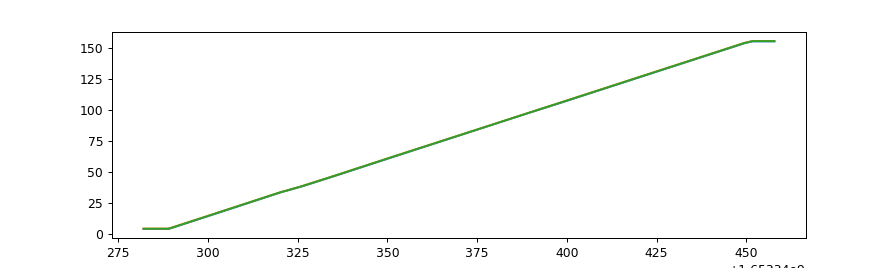

In [12]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,1])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,1])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,1])
plt.show()

<IPython.core.display.Javascript object>


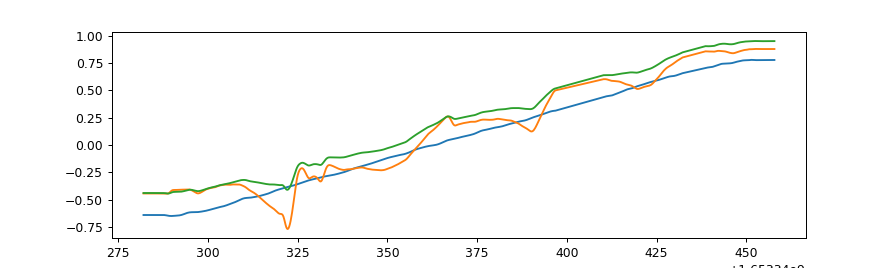

In [13]:
plt.figure(figsize=(10,3))
plt.plot(np.array(trimble_1)[:,0],p1s_r[:,2])
plt.plot(np.array(trimble_1)[:,0],p2s_rarr[:,2])
plt.plot(np.array(trimble_1)[:,0],p3s_rarr[:,2])
plt.show()

In [14]:
dist_prism = []
timestamp = np.array(trimble_1)[:,0]
for i in range(0,len(timestamp)-1):
    dp1 = abs(np.linalg.norm(p1s_r[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_r[i,0:3]-p3s_rarr[i,0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(p3s_rarr[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_23)*1000
    dist_prism.append(np.array([timestamp[i], dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

Mean inter-prism [mm]:  19.31 8.22 15.33
Std inter-prism [mm]:  18.95 5.46 13.544


<IPython.core.display.Javascript object>


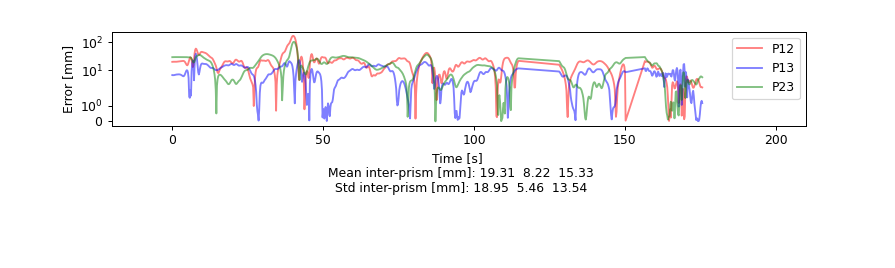

In [20]:
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism[:,1]),2), round(np.mean(dist_prism[:,2]),2), round(np.mean(dist_prism[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism[:,1]),2), round(np.std(dist_prism[:,2]),2), round(np.std(dist_prism[:,3]),3))
plt.figure(figsize=(10,3))
offset_timestamp = min(dist_prism[:,0])
plt.subplot(211)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
limitx = [-20, 210]
ax.set_xlim(limitx)
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism[:,1]),2)) + "  " + str(round(np.mean(dist_prism[:,2]),2)) + "  " + str(round(np.mean(dist_prism[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism[:,1]),2)) + "  " + str(round(np.std(dist_prism[:,2]),2)) + "  " + str(round(np.std(dist_prism[:,3]),2)))
plt.savefig("./figs/20220523_other_dynamic_split_1s.jpg")
#plt.savefig("./figs/20220523_empty.jpg")
plt.show()  

In [21]:
# Convert point data to csv file
ttfu = importlib.reload(ttfu)

# Trajectory total station (time, point data) x3
ttfu.Convert_datap_to_csv(np.array(trimble_1)[:,0], np.array(p1s_r), "./data/prediction/nr_trimble_1.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_2)[:,0], np.array(p2s_rarr), "./data/prediction/nr_trimble_2.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_3)[:,0], np.array(p3s_rarr), "./data/prediction/nr_trimble_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [47]:
ttfu = importlib.reload(ttfu)
save_tf = True
name_file = './data/calibration/tf_automated_resection/20220505_empty_tf_a.csv'
if(save_tf):
    ttfu.save_tf(np.identity(4), T12, T13, name_file)

Conversion done !
